Presented Below are two plots in subplot configuration.  The upper plot is a sum of the cusp crossings.  The lower plot is a plot of the cusp latitude and the spacecraft latitude/longitude plotted against time.  Also included is the process of thoughts that led to that conclusion.

I used the Tsyganenko model of the cusp position.  This model describes the cusp position in the noon-midnight meridian using a cylindrical coordinate system.  The $r$ and $\theta$ components are occuring in the xz plane.  The neutral axis is therefore the $y$ axis.  

Tsyganenko provides the following equation for a simplified cusp model
\begin{equation}
\phi_{c} = arcsin(\frac{\sqrt{\rho}}{\sqrt{\rho + \sin^{-2}(\phi_{1}) -1}}) + \psi(t)
\end{equation}

Here, $\rho$ is the radial of the satellite from the center of the earth.  $\phi_{c}$ is the colatitude of the cusp position.  $\psi$ is the dipole tilt of the cusp.  $\phi_{1}$ is provided by the equation $\phi_{c0} - (\alpha_{1} \psi + \alpha_{2}\psi^{2})$.  As in (Tsyganenko) the values of $\phi_{c}$, $\alpha_{1}$, and $\alpha_{2}$ are 0.24, 0.1287, and 0.0314 respectively.  ((note that that last sentence is almost a literal copy paste of the Tsyg paper)).  Note that $\psi (t)$ is my own addition and that the original notation is $\psi$.  I want to make it extremely clear that $\psi$ varies with time, requiring that the tsyganenko library be a function of time as well.

The dataset used here depicts the path of a satellite on a single day of its orbit 01-Jan-2019, at a $65^{\circ}$ inclined orbit.  

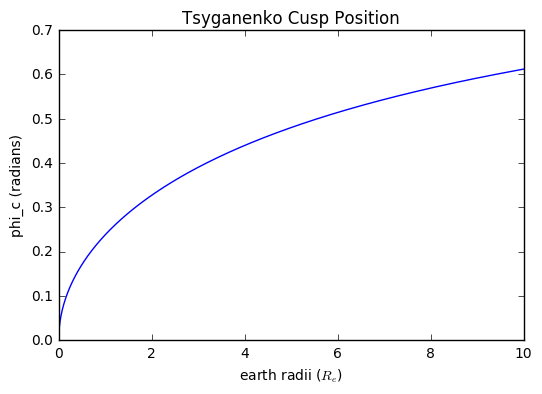

In [1]:
import tsyganenko as tsyg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from spacepy import coordinates as coord
import spacepy.time as spt
from spacepy.time import Ticktock
import datetime as dt
from mpl_toolkits.mplot3d import Axes3D
import sys

#adding the year data here so I don't have to crush my github repo
pathname = '../../data-se3-path-planner/yearData/cuspCrossings2019/'
sys.path.append(pathname)

# find phi for a stationary cusp
r = np.linspace(0,10, 1000)
phi_c = tsyg.getPhi_c(r)
plt.plot(r,phi_c)
plt.ylabel('phi_c (radians)')
plt.xlabel('earth radii ($R_{e}$)')
plt.title('Tsyganenko Cusp Position')
plt.show()



Note that below, there are many ways that we could set up the subplot, but I just chose (programattically) to do it a certain way provided in http://matplotlib.org/examples/pylab_examples/subplots_demo.html

Note: The units for this system is solar magnetic degrees.  Some plots I did gave me that kind of bias to think that SM would be the best coordinate system for this. (That's probably not true but there are many ways to solve this problem).

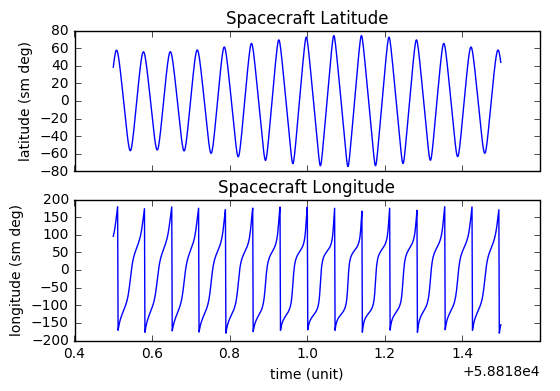

In [2]:
# the orbit is fairly easy to get 
df = pd.read_csv('singleday.csv')
# df = pd.read_csv('5day.csv')
t = df['DefaultSC.A1ModJulian'] + 29999.5
x = df['DefaultSC.gse.X']
y = df['DefaultSC.gse.Y']
z = df['DefaultSC.gse.Z']

# set the "ticks"
cvals = coord.Coords([[i,j,k] for i,j,k in zip(x,y,z)], 'GSE', 'car')
cvals.ticks = Ticktock(t,'MJD')
# originally SM
sm = cvals.convert('SM', 'sph')


# t = np.asarray(t)
# plotting stuff
f, axarr = plt.subplots(2, sharex=True)
# axarr[0].plot(t, y)
axarr[0].set_title('Spacecraft Latitude')
axarr[0].set_ylabel('latitude (sm deg)')
axarr[0].plot(sm.ticks.MJD, sm.lati)
axarr[1].set_title('Spacecraft Longitude')
axarr[1].set_ylabel('longitude (sm deg)')
axarr[1].plot(sm.ticks.MJD, sm.long)

plt.xlabel('time (unit)')

plt.show()

The next thing to do is compute the cusp latitude and longitude using tsyganenko.  The cusp angular position is a function of radial distance from the earth as given in the Tsyganenko equation.  This means that different "tracks" will be given as we vary $R_{e}$.  Since I am using a very circular orbit, with $e \sim 0.02$, I will plot the cusp latitude and longitude below as a function of the spacecraft altitude in my GMAT file.  The semi major axis is given as $7191 km$, $\sim 1.127 R_{e}$.  

type(phi_c) True
x 0.280402041113
y 0
z 1.0915602115


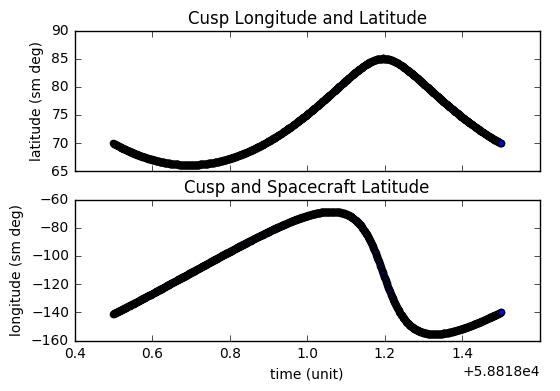

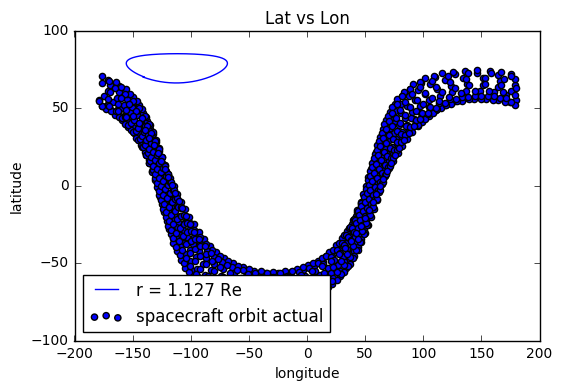

In [3]:
rs = 1.127 # average of the radius of the orbit
# rs = np.array([1,2,3])
phic = tsyg.getPhi_c(rs)
x,y,z= tsyg.tsygCyl2Car(phic,rs)
# print("x,y,z",xt,yt,zt)
print("x",x)
print("y",y)
print("z",z)

# next lets put these three coordinates into a spacepy coordinates object

singletrack = coord.Coords([[x,y,z]]*len(t), 'SM', 'car')
singletrack.ticks = Ticktock(t,'MJD')
singletrack = singletrack.convert('GEI','sph')
f, axarr2 = plt.subplots(2, sharex=True)
# axarr[0].plot(t, y)
axarr2[0].set_title('Cusp Longitude and Latitude')
axarr2[0].set_ylabel('latitude (sm deg)')
axarr2[0].scatter(singletrack.ticks.MJD, singletrack.lati)
axarr2[1].set_title('Cusp and Spacecraft Latitude')
axarr2[1].set_ylabel('longitude (sm deg)')
axarr2[1].scatter(singletrack.ticks.MJD, singletrack.long)
plt.xlabel('time (unit)')
f,axarr3 = plt.subplots(1)
axarr3.set_title('Lat vs Lon')
axarr3.set_ylabel('latitude')
axarr3.set_xlabel('longitude')
axarr3.plot(singletrack.long,singletrack.lati, label='r = 1.127 Re')
axarr3.scatter(sm.long,sm.lati,label='spacecraft orbit actual')
axarr3.legend(loc='lower left')
plt.show()

So I suppose this does show that for a region of the stationary cusp, that the satellite potentially crosses it.  However, the cusp location moves throughout the day so it's conceivable that the cusp avoids the orbit of the satellite, and I need a way to test for that.  The other big question is how do I integrate dipole tilt into this at the same time.  The first question I need to answer is whether or not the dipole tilt matters in SM.

One other approach I could take is to come up with the cusp position as $f(\rho,t)$, then compare that latitude and longitude to the spacecraft latitude and longitude. That's really what I need to do.

Step by Step what I will attempt to do:

1.  Move the cusp and prove that it is moving.  I'll use the r = 1.127Re track to do this and one years worth of data. x

2.  Once I have the cusp latitude and longitude, compare the satellite latitude and longitude.

3.  Do the cusp crossings count.

4.  Plot the lat/lon of the cusp/spacecraft and the cusp crossings subplots together.

From here one we will be using the data from a year's flight around the earth, because these trends are periodic over a year.


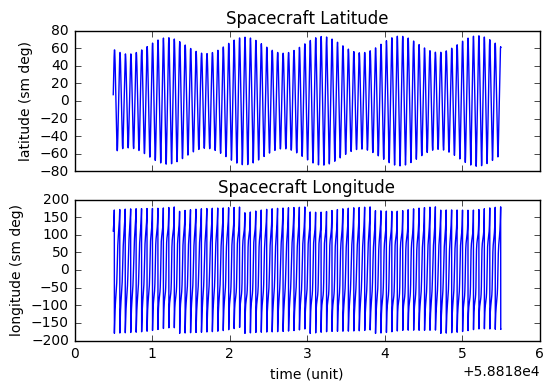

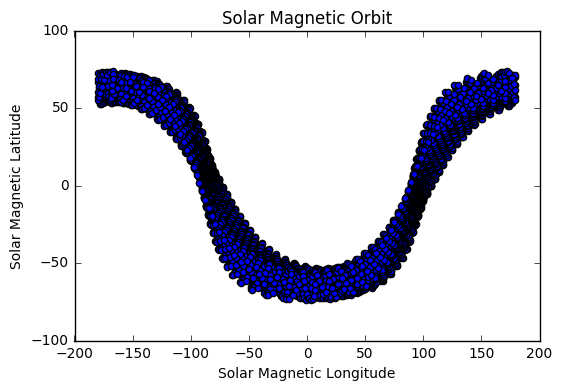

In [4]:
# the orbit is fairly easy to get 
#df = pd.read_csv(pathname+'zero.csv')
df = pd.read_csv('5day.csv')
# df =pd.read_csv(pathname+'zero_year.csv')
t = df['DefaultSC.A1ModJulian'] + 29999.5
x = df['DefaultSC.gse.X']
y = df['DefaultSC.gse.Y']
z = df['DefaultSC.gse.Z']

# set the "ticks"
cvals = coord.Coords([[i,j,k] for i,j,k in zip(x,y,z)], 'GSM', 'car')
cvals.ticks = Ticktock(t,'MJD')
sm = cvals.convert('SM','sph')
spacecraft_gei = cvals.convert('GEI', 'sph')
spacecraft = cvals.convert('GSM','sph')


# t = np.asarray(t)
# plotting stuff
f, axarr = plt.subplots(2, sharex=True)
# axarr[0].plot(t, y)
axarr[0].set_title('Spacecraft Latitude')
axarr[0].set_ylabel('latitude (sm deg)')
axarr[0].plot(sm.ticks.MJD, sm.lati)
axarr[1].set_title('Spacecraft Longitude')
axarr[1].set_ylabel('longitude (sm deg)')
axarr[1].plot(sm.ticks.MJD, sm.long)

plt.xlabel('time (unit)')

plt.show()

f, a = plt.subplots(1)
plt.title('Solar Magnetic Orbit')
plt.xlabel('Solar Magnetic Longitude')
plt.ylabel('Solar Magnetic Latitude')
a.scatter(sm.long,sm.lati)
plt.show()

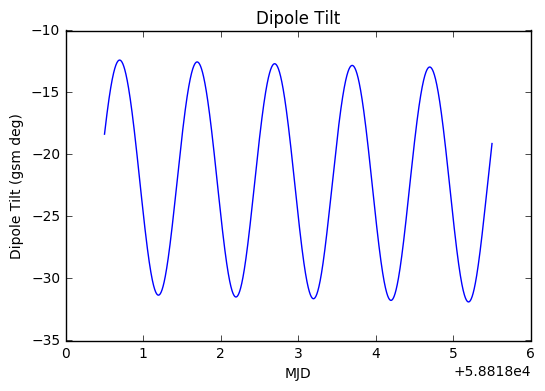

In [5]:
psi = tsyg.getTilt(t)
plt.plot(t,psi)
plt.title('Dipole Tilt')
plt.xlabel('MJD')
plt.ylabel('Dipole Tilt (gsm deg)')
plt.show()
# here the OUTPUT, psi is in degrees

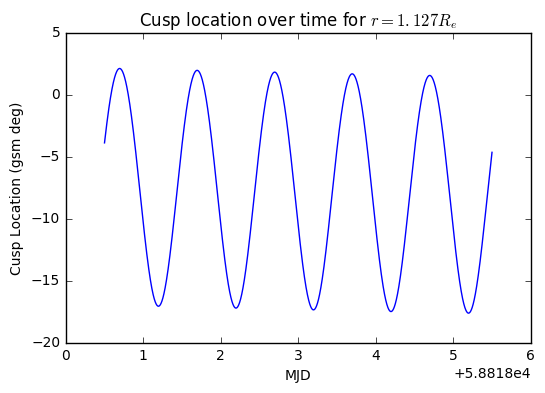

In [6]:
# output cusp position with the dipole tilt
r = 1.127
psi = np.deg2rad(psi)
phi_c = tsyg.getPhi_c(r,psi)
phi_c = np.rad2deg(phi_c)
plt.figure()
plt.plot(t,phi_c)
plt.title('Cusp location over time for $r = 1.127R_{e}$')
plt.xlabel('MJD')
plt.ylabel('Cusp Location (gsm deg)')
plt.show()

type(phi_c) False


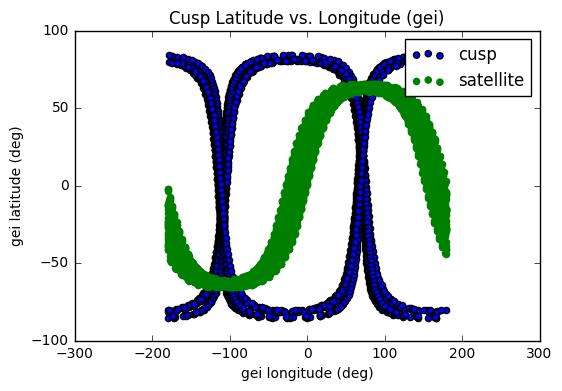

In [7]:
# next lets get the spherical coordinates and plot the latitude and longitudes, which SHOULD
# allow us to get the cusp crossings.
xc,yc,zc = tsyg.tsygCyl2Car(phi_c,r)

#originally it was GSM
cusp_location = coord.Coords([[i,j,k] for i,j,k in zip(xc,yc,zc)], 'GSM', 'car')
cusp_location.ticks = Ticktock(t,'MJD')
cusp_location = cusp_location.convert('GEI','sph')
plt.scatter(cusp_location.long, cusp_location.lati,label='cusp')
plt.scatter(spacecraft_gei.long,spacecraft_gei.lati,color='green', label='satellite')
plt.xlabel('gei longitude (deg)')
plt.ylabel('gei latitude (deg)')
plt.title('Cusp Latitude vs. Longitude (gei)')
plt.legend()
plt.show()


The biggest issues of this plot are that we aren't able to see where the cusp is at a certain time, it's just a ground track.  Therefore, we need to also put in the plots of lat/lon vs. time.

Close to solving this.  I think my cusp actually behaves somewhat correctly. The above plot was actually really promising, but for some reason my  Now I need to use the Tsyganenko equation as an function of the satellite's location.  It really don't make much sense to me why the cusp wouldn't seem to change in latitude.  My guess is that there's tiny circles there if you look closely at the data.  

I'll deal with what I suspect are innacuracies later I feel like I've done okay thus far.  Like I "feel" like the equations are wrong. 
Open Questions at this point:
1.  should the latitude go so low?
2.  

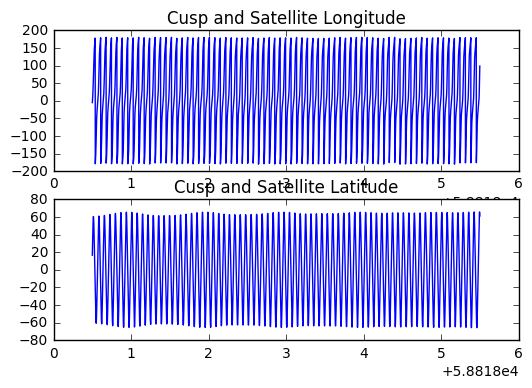

In [8]:
# plot of the latitude and the longitude of the spacecraft at each timestep, 
f,ax = plt.subplots(2)
# i can probably use a list comprehension here for the cusp location
# just feel really unmotivated rn
# xk,yk,zk = tsyg.tsygCyl2Car()
# longitude vs. time
ax[0].set_title('Cusp and Satellite Longitude')
ax[1].set_title('Cusp and Satellite Latitude')
ax[0].plot(spacecraft_gei.ticks.MJD, spacecraft_gei.long)
ax[1].plot(spacecraft_gei.ticks.MJD, spacecraft_gei.lati)
plt.show()

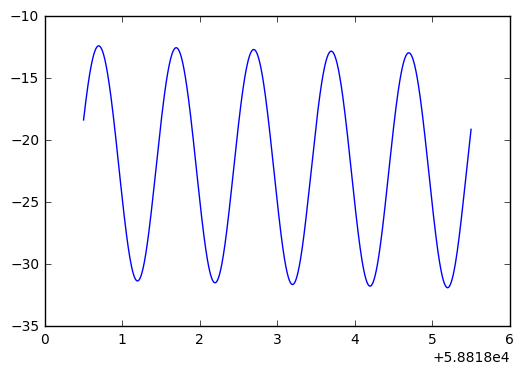

type(phi_c) False
x equals to [-104733.37565103 -104798.56427133 -104911.56430213 ..., -108742.63476943
 -108315.22737881 -108295.21510812]
y equals to [ 0.  0.  0. ...,  0.  0.  0.]
z equals to [-57004.08772786 -56823.32595724 -56551.85463313 ..., -56213.45766327
 -56051.86544492 -56044.70554969]
satx [-2680.65509425 -2987.50454453 -3448.21846429 ..., -5436.96364209
 -5424.86233887 -5423.15368108]
saty [ 6701.54502995  6573.05542831  6319.72771326 ...,    39.48838224
  -710.98866465  -741.19508038]
satz [   58.1590681    353.10929118   815.39410782 ...,  4962.99015555
  4920.96878622  4918.16001834]


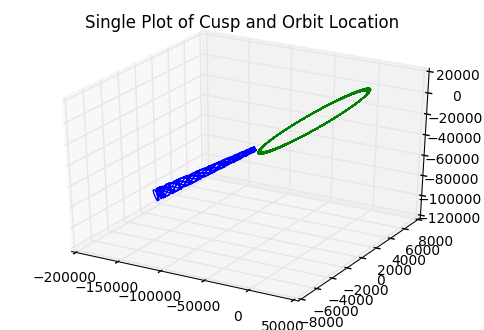

In [9]:
# testing the function for 
x,y,z = tsyg.orbitalCuspLocation(cvals,t)
gsm2 = spacecraft_gei.convert('GSM','car')
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')

# my present guess is again, a disagreement between the 
# coordinate systems
ax.plot(x,y,z)
ax.plot(gsm2.x,gsm2.y,gsm2.z)
print("satx",gsm2.x)
print("saty",gsm2.y)
print("satz",gsm2.z)
ax.set_title('Single Plot of Cusp and Orbit Location')
plt.show()

# okay lets look at the coordinate systems here.  My initial 
# thought is that if it's the cusp location it's probably okay for it 
# to be really big, esp if the corresponding location is like in the
# nightside of the earth, so let's not panic because these values
# are really high.

So I think the main way we can test for cusp crossings is that I can plot the latitude and Longitude vs. time of each component, then, I can do the summation similar to how I was making the colormap earlier

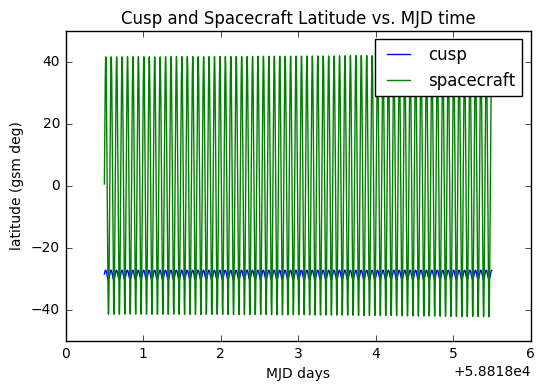

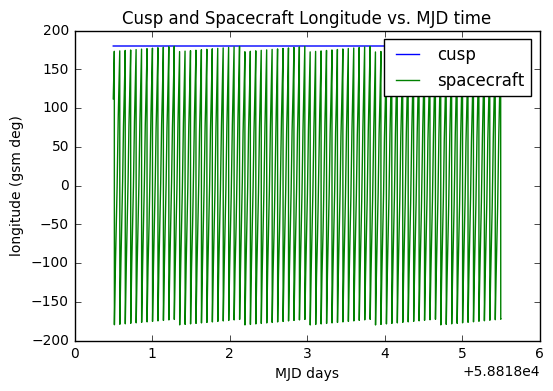

In [10]:
# gsm is the satellite orbit (terrible variable name)
# x,y,z is the coordinates output from the cusp model (i think it's in gsm)
# note that x,y,z are all np.ndarray typreddit.com/r/smashbroses

# instatiate the cusp coordinates to a spacepy coords object
cusp_location = coord.Coords([[i,j,k] for i,j,k in zip(x,y,z)], 'GSM', 'car')
cusp_location.ticks = Ticktock(t,'MJD')
cusp_location = cusp_location.convert('GSM','sph')

# put whatever conversions here to maintain consistency
system = 'GSM'
cusp_location = cusp_location.convert(system,'sph')
spacecraft = spacecraft.convert(system,'sph')

plt.plot(cusp_location.ticks.MJD,cusp_location.lati, label='cusp')
plt.plot(spacecraft.ticks.MJD, spacecraft.lati,label='spacecraft')
plt.title('Cusp and Spacecraft Latitude vs. MJD time')
plt.xlabel('MJD days')
plt.ylabel('latitude (gsm deg)')
plt.legend()
plt.show()

plt.plot(cusp_location.ticks.MJD, cusp_location.long,color='blue', label='cusp')
plt.plot(spacecraft.ticks.MJD, spacecraft.long, color='green', label='spacecraft')
plt.title('Cusp and Spacecraft Longitude vs. MJD time')
plt.xlabel('MJD days')
plt.ylabel('longitude (gsm deg)')
plt.legend()
plt.show()

In [11]:
count = 0
thresh = 2 #degrees
for satlat, cusplat, satlong, cusplong in zip(spacecraft.lati, cusp_location.lati, spacecraft.long, cusp_location.long):
    if abs(cusplat-satlat)<=thresh and abs(satlong-cusplong)<=thresh:
        count+=1
    else:
        pass
    
print("count = count",count)
print("lenght of spacecraft.lati",len(spacecraft.lati))

count = count 0
lenght of spacecraft.lati 4341
